# PATH

구글 드라이브

In [1]:
import os
import sys
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/RNN')

Mounted at /content/drive


In [2]:
os.getcwd()

'/content/drive/My Drive/RNN'

In [3]:
import torch

In [4]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [5]:
device

'cuda'

# Data

In [6]:
import pandas as pd
import torch

본 구현 코드에서 사용할 데이터 셋은 영어-프랑스어 번역 작업을 위한 데이터 셋입니다!

즉 영어를 입력했을 때 프랑스어로 번역된 문장을 출력하는 모델을 만든다고 생각하시면 됩니다.

관련 전처리 과정은 아래에서 진행될 것이고, 이후에 모델링에서 진행하실 때 도움이 되는 내용들로 구성했습니다. 특히 자연어라는 데이터 특성상 전처리에서 보다 고려해야할 점이 많으며, 현재 과정에서 언급되지 않은 부분들도 고려를 해야합니다. 그렇기 때문에 다음 파일인 **RNN 과제 코드**에서 실제 큰 데이터 셋을 이용할 때 전처리에 관련하여 보다 더 자세히 전달드리도록 하겠습니다.

현재 **RNN 실습 코드**에선 "Seq2Seq 모델 구현"을 목표로, 현재 모델 설명을 들을 상태에서 실제로 구현까지 어떻게 진행되는지 이해해보고, 추후에도 모델을 구현해야하는 상황에서 모델 코드의 독해력을 기를 수 있는 기회를 제공하고자 합니다. 

In [7]:
# Seq2Seq 구현 설명에서 사용할 데이터 선택
# 입력 시퀀스에 해당하는 것이 src
# 출력 시퀀스에 해당하는 것이 tar
# 파일을 읽어올 때 편의상 lic라는 column이 필요해서 src와 tar과 함께 불러옴
lines = pd.read_csv('data/fra.txt', names=['src', 'tar', 'lic'], sep='\t')
# 이후 과정에서는 lic라는 column은 필요없어서 제외
del lines['lic']
print('전체 샘플의 개수 :',len(lines))

전체 샘플의 개수 : 194513


In [8]:
# 현재 데이터의 상태 
lines.head()

,src,tar
0,Go.,Va !
1,Go.,Marche.
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.


In [9]:
# 모든 데이터를 다 쓰게 되면 학습이 오래 걸리기도 하고, 구현 설명에서는 돌아가는 방식을 이해하기 위한 것이기에
# 일부 데이터만 사용. 
lines = lines[:60000]
lines.head()

,src,tar
0,Go.,Va !
1,Go.,Marche.
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.


# 시작하기에 앞서

1. 현재 Seq2Seq 모델이 돌아가는 구조입니다. 
   - 아래의 예시는 영어에서 프랑스어로 번역하는 모델인 것이고, 저희 모델에서 사용할 구조는 영어에서 프랑스어로 번역하는 구조임을 유의하시길 바랍니다. 
   - 여기서 주목할 점은 Seq2Seq 모델에서 요구하는 데이터의 구조입니다. 
2. 우선 좌측의 **Encode**r의 경우 문장이 시작하고 끝이 날 때 문장의 끝을 알려주는 역할로 \<EOS\>라는 토큰이 붙어있습니다. 
3. 우측의 **Decoder**의 경우 입력 데이터로 번역된 단어들이 들어가게 됩니다. 
   - 이 때 **입력 시퀀스**는 문장의 시작을 알리는 \<SOS\> 토큰으로 시작이 되고
   - **출력 시퀀스**는 다음 단어들을 **순차적으로** 예측하기 위해 이전 단계에서의 출력 단어를 다시 **입력 단어**로 사용해 최종 문장의 끝을 알리는 \<EOS\> 토큰으로 끝이 나게 됩니다.
   - 그렇기 때문에 입력 시퀀스와 출력시퀀스는 한 단어(혹은 토큰)씩 차이가 나는 구조가 되어야 합니다.


# 요약하자면

1. 데이터 전처리를 할 때에 문장의 시작과 끝을 알리는 토큰을 Encoder와 Decoder에 각각 맞춰서 정리해야 합니다.
2. \<EOS\>와 \<SOS\>는 하나의 토큰으로서, 다른 형태의 토큰을 사용하여도 좋습니다. (ex. \<s\>, \</s\>).
3. 본 코드에서는 편의상 \\t와 \\n 을 각각 시작토큰, 종료 토큰으로 사용하겠습니다.

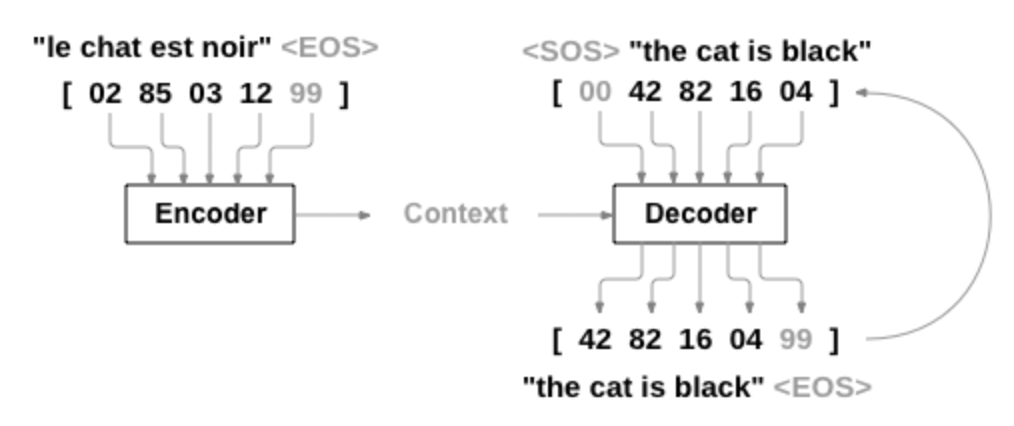

# Preprocess

## EOS, SOS 토큰 추가

In [13]:
# 시작 토큰에 해당하는 \t를 원래 문장 앞에 붙여주고, 종료 토큰에 해당하는 \n을 문장 끝에 붙여주는 과정입니다.
# 위의 구조에서 보면 알 수 있듯, Encoder에서는 종료토큰만 붙여줍니다.

# Decoder의 경우 입력 시퀀스와 출력 시퀀스 데이터를 모두 만들어야 하는 상황인데, 
# 각각 입력 시퀀스, 출력 시퀀스 따로 나눠서 진행하여도 좋습니다!
# 다만 이후의 코드는 먼저 시작 토큰과 종료토큰을 번역된 문장에 먼저 붙여놓고 처리해보고자 합니다.

lines.src = lines.src.apply(lambda x: x+'\n')
lines.tar = lines.tar.apply(lambda x : '\t '+ x + ' \n')
lines[:5]

,src,tar
0,Go.\n,\t Va ! \n
1,Go.\n,\t Marche. \n
2,Go.\n,\t Bouge ! \n
3,Hi.\n,\t Salut ! \n
4,Hi.\n,\t Salut. \n


## 단어 집합 확인(토큰 확인)

In [14]:
# 지금은 문장형태로 데이터가 주어져있습니다. 저희는 모델이 알 수 있는 형태로 데이터를 처리해야합니다.
# 그렇게 하기 위해 Tokenization이 필요로 하는데, 본 실습 코드에서는 알파벳 하나하나를 하나의 token으로 보고 처리해보고자 합니다.
# 즉 입력 시퀀스에 사용된 문자 집합 구축하여 token으로 사용하고, 출력시퀀스도 동일하게 알파벳별로 token화 시키기 귀해서
# 문자집합을 만들어 줍니다.

# 입력 시퀀스에서 사용할 문자 집합
src_vocab = set()

# 1줄씩 읽으며, 이 때 1줄에 해당하는 line은 str typedml 문자열입니다.
for line in lines.src: 
    # 현재 알파벳을 token으로 사용하기 때문에 문자열을 iter하는 경우 문자 하나하나 나오게 됩니다.
    # 이 점을 이용해서 tokenization을 하는 것입니다!
    for char in line: 
        # type이 set이기 때문에 add를 할 경우 합집합이 계산되어서 최종 결과는 
        # 입력 시퀀스에서 사용하는 unique한 알파벳으로 구성된 집합이 됩니다.
        src_vocab.add(char)

# 출력 시퀀스에 대해서도 동일하게 진행됩니다.
tar_vocab = set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)

In [15]:
# 앞서 정리한 알파벳(토큰)들의 개수를 확인하려고 합니다.
# 여기서 주의할 점은 최종 개수를 계산할 때 +1을 합니다. 이렇게 계산하는 이유는
# 이후에 사용될 padding에 사용되는 값을 고려한 것입니다.
# padding에서 좀 더 정확히 언급할 예정이고 여기서 간략히 말하자면
# 모든 시퀀스(문장)들이 길이가 다를 텐데, 모델의 입장에서는 이렇게 입출력 값들의 형태가 달라지면 
# 값을 처리하기 힘듭니다. 그래서 동일한 길이로 만들어주는 과정이 padding에 해당하고
# 데이터 상으로 "이건 padding으로 추가된 토큰임"을 말해주는 값이 필요합니다.
# 이는 모델 입장에서 다른 토큰과 동일한 토큰이기 때문에 최종 개수는 padding을 위한 토큰을 고려해서 +1을 해야합니다.
# 자세한 형태는 이후 예시에서 확인하도록 합니다.
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
print('source 문장의 char 집합 :',src_vocab_size)
print('target 문장의 char 집합 :',tar_vocab_size)

source 문장의 char 집합 : 81
target 문장의 char 집합 : 105


In [16]:
# 편의상 토큰들을 정리해서 사용하도록 합니다.
# 다만 현재 set형태로 되어 있기 때문에 list 형태로 만들어주어야 sort가 됩니다.
# 이후로는 list type을 사용하고 있습니다.
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
print(src_vocab[45:75])
print(tar_vocab[45:75])

['V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']
['T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']


## token - index 

컴퓨터는 숫자만 이해합니다. 그렇기 때문에 앞서 구한 문자 집합들을 숫자로 만들어야 하고, 그렇지만 다른 문자들은 다른 숫자들을 가져야 구분이 가능합니다!

즉 일종의 문자들의 index값이 필요로 하게 되고 아래의 과정에서는 앞서 정리한 토큰들별로 숫자값(정수형)을 할당하는 과정입니다.

In [17]:
# 앞에서도 vocab size에 +1을 한 것과도 동일한 맥락으로 여기서 i+1을 해주는 이유도 이후에 padding과 관련있습니다. 
# 이후에 padding에 사용된 토큰을 위한 자리로 0을 사용할 것이기 때문에 i+1을 한 값을 사용합니다.
# 원래라면 range를 사용하면 "0"부터 시작해서 카운트를 하지만 padding용 토큰으로 "0"을 사용하기 때문에 1부터 시작하기로 합니다.
# 이렇게 하지 않은 경우(= i를 사용하면) token이 겹치게 될거에요!
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)

{'\n': 1, ' ': 2, '!': 3, '"': 4, '$': 5, '%': 6, '&': 7, "'": 8, ',': 9, '-': 10, '.': 11, '/': 12, '0': 13, '1': 14, '2': 15, '3': 16, '4': 17, '5': 18, '6': 19, '7': 20, '8': 21, '9': 22, ':': 23, '?': 24, 'A': 25, 'B': 26, 'C': 27, 'D': 28, 'E': 29, 'F': 30, 'G': 31, 'H': 32, 'I': 33, 'J': 34, 'K': 35, 'L': 36, 'M': 37, 'N': 38, 'O': 39, 'P': 40, 'Q': 41, 'R': 42, 'S': 43, 'T': 44, 'U': 45, 'V': 46, 'W': 47, 'X': 48, 'Y': 49, 'Z': 50, 'a': 51, 'b': 52, 'c': 53, 'd': 54, 'e': 55, 'f': 56, 'g': 57, 'h': 58, 'i': 59, 'j': 60, 'k': 61, 'l': 62, 'm': 63, 'n': 64, 'o': 65, 'p': 66, 'q': 67, 'r': 68, 's': 69, 't': 70, 'u': 71, 'v': 72, 'w': 73, 'x': 74, 'y': 75, 'z': 76, '°': 77, 'é': 78, '’': 79, '€': 80}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, ',': 12, '-': 13, '.': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 

결과를 보면 알 수 있듯이 입력 시퀀스에 EOS로 사용되는 토큰이 1번으로 되어있고, 출력 시퀀스에 대해선 1,2번에 SOS와 EOS 토큰으로 사용되는 것이 배치되어 있습니다.

그리고 공통적으로 0번 토큰은 모두 비어져 있는데, 이후에 0번은 padding에 사용될 토큰이 사용합니다! 그렇기에 1번부터 시작합니다.

여기서 한번 고민해볼 점은 다음과 같습니다.
1. 알파벳단위로 토큰화를 했는데, 여기에 의도치 않게 특수문자를 포함해서 여러 기호들이 포함되어 있습니다. 현재 전처리 과정에서 특수문자를 처리하는 과정이 제외되어 있지만 실제 데이터에서는 필요로 합니다.
   - 그런데, ?나 !처럼 context에 영향을 줄 수 있는 기호들도 있을 수 있습니다. 그런 것들까지 빼야할까요?

## 정수인코딩

지금까지 진행한 경우에 단어집합까지는 구했지만 실제 데이터는 아직 str로 구성되어 있습니다. 컴퓨터는 숫자 데이터로 알려줘야 하기 때문에 앞서 정리한 token-index를 이용하여 숫자로 바꾸는 과정입니다.

이 과정에서 torch에서 Tensor의 type에 대한 설명을 참고하실 분들은 [레퍼런스](https://pytorch.org/docs/stable/tensors.html)를 이용하시기 바랍니다.

In [20]:
# 현재 2가지 언어에 대해서 각각 단어집합을 만든 상태입니다. 즉 사용하는 언어들마다 단어집합도 다르고, index도 다릅니다.
# 그래서 입력 시퀀스 출력 시퀀스별로 token에 정수형의 숫자들을 할당해놓은 것이 바로 src_to_index, tar_to_index입니다.

# 아래의 코드에서는 이를 이용해서 문자 --> 숫자로 바꿔주는 과정입니다.

# 입력 시퀀스를 먼저 처리하겠습니다.
# 입력 시퀀스는 encoder에 들어가는 값이기에 encoder_input이라고 해보겠습니다.
encoder_input = []

# 1개의 문장
for line in lines.src:
  encoded_line = []
  # 각 줄에서 1개의 알파벳별로 처리. 앞서서 동일한 방식으로 tokenization을 했기 때문!
  for char in line:
    # 각 알파벳을 정수로 바꾸어야합니다. 왜 하필 정수형이냐에 대해선 이후에 있을 Embedding과 관련 있습니다.
    # 우선 각 알파벳을 숫자로 바꿔줍니다.
    encoded_line.append(src_to_index[char])
  # 위에서 사용한 index도 정수형이긴한데, 결국 torch.Tensor를 사용해야 하고, Tensor에서 정수형에 해당하는 type이 LongTensor이기 때문에
  # .long()을 이용하여 정수형으로 만들어 줍니다.
  encoder_input.append(torch.Tensor(encoded_line).long())
print('source 문장의 정수 인코딩 :\n',encoder_input[:5], '\n')

source 문장의 정수 인코딩 :
 [tensor([31, 65, 11,  1]), tensor([31, 65, 11,  1]), tensor([31, 65, 11,  1]), tensor([32, 59, 11,  1]), tensor([32, 59, 11,  1])] 



위의 샘플에서 보면 알 수 있듯이 모든 문장에는 마지막에 1이란 토큰이 사용되었고, 
Encoder의 index를 보면 문장 종료를 알리는 \\n 에 해당하는 값입니다! 즉 의도한 대로 값들이 처리된 것을 확인할 수 있습니다.

Decoder의 입력값은 <SOS>에서 시작하고, 출력값은 <EOS>으로 끝나야 합니다.

그런데 지금 데이터는 출력 시퀀스에 <SOS>과 <EOS>가 모두 붙어있는 형태입니다.

이번 단계에서 Decoder의 입력 데이터와 출력 데이터를 아래의 구조에 맞게 정리하는 과정이 필요합니다.

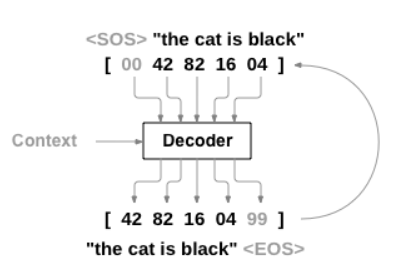

In [21]:
# decoder에 사용할 입력값도 숫자로 바꾸는 과정이 들어갑니다.
# 또한 Decoder의 경우 입력 데이터와 출력 데이터의 형태가 1 step씩 차이가 나는 구조입니다!
# 이를 유의하여 보셔야 합니다.


# 현재 데이터는 "<SOS> 문장 <EOS>" 구조입니다.
# 아래의 코드는 Decoder의 입력 데이터를 만드는 코드이기에 EOS가 제외되어야합니다.
# 그리고 EOS는 문장(list)에서 맨 마.지.막.에 있습니다!

decoder_input = []
# 여기서 line은 문자열에 해당합니다. 
for line in lines.tar:
  encoded_line = []
  for char in line:
    encoded_line.append(tar_to_index[char])
  # 현재 데이터 상 문장 맨 마지막에는 <EOS>가 들어가 있는데, decoder를 학습할 때 <EOS>를 넣지 않으니 마지막의 값을 pop하여 제외합니다.
  encoded_line.pop(-1)

  # 여기서 .long()은 정수 인코딩된 문장들의 type을 정하는 것으로, 이후에 Embedding layer를 사용할 때 해당 타입을 사용해야하기 때문에 사용한 것입니다.
  decoder_input.append(torch.Tensor(encoded_line).long())  
print('target 문장의 정수 인코딩 :\n',decoder_input[:5],'\n')

target 문장의 정수 인코딩 :
 [tensor([ 1,  3, 48, 53,  3,  4,  3]), tensor([ 1,  3, 39, 53, 70, 55, 60, 57, 14,  3]), tensor([ 1,  3, 28, 67, 73, 59, 57,  3,  4,  3]), tensor([ 1,  3, 45, 53, 64, 73, 72,  3,  4,  3]), tensor([ 1,  3, 45, 53, 64, 73, 72, 14,  3])] 



위의 예시에서 알 수 있듯이 모든 문장은 1번 토큰을 사용하는데 이는 Decoder의 단어집합에서 문장 시작을 알리는 토큰에 해당합니다! 즉 SOS는 들어가있고 EOS는 들어가지 않습니다.

다만 3번 토큰은 띄어쓰기를 한 토큰인데, 이게 모든 문장 뒤에 붙어 있다보니 마치 EOS로 보일 수 있는데, 이건 전처리를 대충해서 나온 현상이고 EOS는 2번 토큰임을 참고하시길 바랍니다.

In [22]:
# decoder에서 출력할 값도 숫자로 바꿔주는 과정입니다.
# 앞선 과정과 비슷하게 진행되고 차이점으로는 1step씩 차이가 나야 합니다.
# 이를 유의하여 보시길 바랍니다.

decoder_target = []
for line in lines.tar:
  # 여기서 timestep은 시퀀스 상 몇번째 값인지 알려주는 값입니다.
  timestep = 0
  encoded_line = []
  for char in line:
    # Decoder가 출력하는 값에서 문장의 시작을 알리는 값(SOS)가 들어가면 안됩니다.
    # 반면 현재 데이터는 SOS로 시작하는 형태입니다. 
    # 그래서 시퀀스에서 0번째를 제외한 경우만 추가를 하게 된다면 적절히 제외될 것입니다. 
    if timestep > 0:
      encoded_line.append(tar_to_index[char])
    timestep = timestep + 1
  
  decoder_target.append(torch.Tensor(encoded_line).long())
print('target 문장 레이블의 정수 인코딩 :\n',decoder_target[:5],'\n')

target 문장 레이블의 정수 인코딩 :
 [tensor([ 3, 48, 53,  3,  4,  3,  2]), tensor([ 3, 39, 53, 70, 55, 60, 57, 14,  3,  2]), tensor([ 3, 28, 67, 73, 59, 57,  3,  4,  3,  2]), tensor([ 3, 45, 53, 64, 73, 72,  3,  4,  3,  2]), tensor([ 3, 45, 53, 64, 73, 72, 14,  3,  2])] 



위의 결과에서 모든 문장은 마지막에 2번 토큰이 들어가있고, Decoder의 index에선 종료 토큰(EOS)를 의미합니다.



In [23]:
# 한번 입력 시퀀스와 출력 시퀀스의 최대 길이를 비교하는 코드입니다.

max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print('source 문장의 최대 길이 :',max_src_len)
print('target 문장의 최대 길이 :',max_tar_len)

source 문장의 최대 길이 : 24
target 문장의 최대 길이 : 76


In [24]:
# 평균적인 문장들의 길이를 확인하는 코드입니다.

avg_src_len = sum(list(map(lambda x: len(x), lines.src)))/ len(lines.src)
avg_tar_len = sum(list(map(lambda x: len(x), lines.tar)))/ len(lines.tar)
print('source 문장의 평균 길이 :',avg_src_len)
print('target 문장의 평균 길이 :',avg_tar_len)

source 문장의 평균 길이 : 19.302833333333332
target 문장의 평균 길이 : 27.17578333333333


기본적으로 모든 문장들의 길이는 다릅니다.

게다가, 지금 문장길이에서 출력 시퀀스는 max값이 평균값과 많은 차이가 생긴 상태입니다. 이것이 과연 모델에 어떤 영향을 끼칠까요? 물론 답은 없습니다. 한번 고민해볼 부분입니다.

또한 동시에 이를 고려해서 어떻게 처리할 수 있을까요?

## Padding

앞서 문장 길이가 다 다를 수 있다는 것을 확인했습니다. 모델 입장에서는 이렇게 입력하는 시퀀스의 길이가 다르다면 처리하기 힘들 것입니다!

그렇다면 길이를 통일해줘야할 것이고, 이것이 바로 padding의 역할입니다.

In [19]:
from torch.nn.utils.rnn import pad_sequence

해당 함수는 tensor를 element로 가지는 list가 들어왔을 때,
1. 모든 tensor를 동일한 길이를 가지도록 함
2. 이 때 가장 긴 tensor의 길이(len)을 사용
3. 가장 긴 tensor 외의 tensor들은 남은 시퀀스들을 다른 숫자들로 값을 채움
4. "다른 숫자"도 지정할 수 있고 기본 값은 0임(arguement는 padding_value)
   - 그렇기 때문에 앞서서 padding에 사용할 토큰을 0으로 한 것입니다!

자세한 설명은 [레퍼런스](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html) 참고

In [28]:
# 이해를 위한 예시
tmp_1 = torch.Tensor([1,2,3,4])
tmp_2 = torch.Tensor([5])
tmp_3 = torch.Tensor([9,10])

# batch_first에 따라서 정리되는 방식이 다릅니다.
# 게다가 이는 데이터의 구조를 바꾸고 이는 향후 모델의 구조도 바꿀 수 있기 때문에 일관된 방식으로 정리해야 합니다.
# bath_first=True와 False를 모두 사용해서 한번 결과를 비교해보세요
# tmp = pad_sequence([tmp_1, tmp_2, tmp_3])
tmp = pad_sequence([tmp_1, tmp_2, tmp_3], batch_first=True)
print(tmp.size())
tmp

torch.Size([3, 4])


tensor([[ 1.,  2.,  3.,  4.],
        [ 5.,  0.,  0.,  0.],
        [ 9., 10.,  0.,  0.]])

In [29]:
# batch_first는 이후에도 꾸준히 사용되는 값으로, 모델을 구성할 때 사용되는 값이니 주의해야 합니다.
# 이름에서 알 수 있듯 batch_first는 차원들을 정할 때 batch가 먼저 오도록 한다는 의미입니다.

batch_first = True

encoder_input = pad_sequence(encoder_input, batch_first=batch_first).long()
decoder_input = pad_sequence(decoder_input, batch_first=batch_first).long()
decoder_target = pad_sequence(decoder_target, batch_first=batch_first).long()

In [30]:
# 지금 우린 모든 데이터를 한번에 padding 시키고 있습니다.
# 그렇기 때문에 여기서 batch_size에 해당하는 것은 바로 데이터 전부라고 할 수 있습니다.
# 그래서 batch_first=True의 경우 60000이 먼저 나오는 것을 확인할 수 있습니다.
encoder_input.size()

torch.Size([60000, 24])

위의 size()에서 알고 갈 것은
1. 모든 문장들의 길이가 24이 되었다
  - 이것의 의미는 24보다 짧은 문장들도 길이가 24이 되었다는 것이고, 그렇다면 남은 공간들을 뭘로 채운 것인가? 이게 바로 padding의 의미
  - 그 때 사용되는 값은 기본 값인 0을 사용했다.
  - 0을 사용한 이유는 사실 앞서서 우리가 token들 별로 정수들을 할당했는데, 이 때 0을 비워뒀었고, 사실 그 0은 padding값을 암시하게 되는 것
  - 즉, 컴퓨터에게 알려줄 때 모든 문장(혹은시퀀스)의 길이는 동일한데, 그 중에 padding이 어디 진행되었는지 알려주는 값은 0이 되는 것
2. 차원이 (batch_size, seq_len) 구조다.
  - 여기서 batch_size에서 사용된 값은 60000인데, 이는 전체 문장들의 개수에 해당하는데, 이는 우리가 입력한 문장의 개수에 해당한 것
  - 만약 우리가 사용한 batch만큼 입력했다면 batch_size에 해당하는 값이 첫번째 차원에 해당할 것
  - 참고로 seq_len은 말 그대로 시퀀스의 길이를 말하는 것

## Train-Validation Split

인덱싱을 활용하여 평가용 데이터를 따로 분리하는 과정인데 지금 사용하는 데이터가 split되어 있지 않기 때문에 하는 것이니 크게 신경쓰지 않아도 됩니다.

In [31]:
import numpy as np

In [32]:
# 임의로 정한 값으로 train에 사용할 데이터의 비중입니다.
split_ratio = 0.9

# 총 60000개의 데이터 중에서 train 데이터로 사용할 것들의 index입니다.
# 즉 0~59999에서 60000*0.9=54000개의 unique한 값을 뽑아줍니다.
idx_train = np.random.choice(np.arange(encoder_input.size(0)), int(encoder_input.size(0)*split_ratio), replace=False)

# 그렇게 뽑고 남은 index를 찾기 위해서 차집합을 이용해 전체 0~59999중 사용되지 않은 값들을 정리합니다.
idx_val = list(set(range(encoder_input.size(0))).difference(set(idx_train)))

In [33]:
# 겹치는 인덱스가 없습니다! 다행이네요.
np.isin(idx_train, idx_val).sum()

0

### Train data

tuple type으로,  (encoder_input, decoder_input, decoder_target)의 순서를 가지게 정리했는데, 이건 필수적인 과정이나 방법은 아니고 이후에 사용하기 편할 것 같아서 정리한 것입니다.

In [34]:
# 앞서 0.9의 비율로 사용하기로 했기 때문에 개수도 총 54000개
len(idx_train)

54000

In [35]:
train_data = tuple([i[idx_train] for i in [encoder_input, decoder_input, decoder_target]])

In [36]:
for i in train_data:
  print(i[0],'\n')
  print(i[0].size(),'\n')


tensor([33, 70,  2, 73, 51, 69,  2, 51,  2, 73, 55, 59, 68, 54,  2, 56, 55, 55,
        62, 59, 64, 57, 11,  1]) 

torch.Size([24]) 

tensor([ 1,  3, 29,  9, 91, 72, 53, 61, 72,  3, 73, 66,  3, 71, 57, 66, 72, 61,
        65, 57, 66, 72,  3, 54, 61, 78, 53, 70, 70, 57, 14,  3,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0]) 

torch.Size([75]) 

tensor([ 3, 29,  9, 91, 72, 53, 61, 72,  3, 73, 66,  3, 71, 57, 66, 72, 61, 65,
        57, 66, 72,  3, 54, 61, 78, 53, 70, 70, 57, 14,  3,  2,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0]) 

torch.Size([75]) 



위에 print가 말하는건 한 샘플에 대해서 encoder의 input값, decoder의 입력값, decoder의 출력값을 순서대로 보여주고 있습니다.

여기에서 decoder의 입력값과 출력값의 길이가 동일하게 됩니다.

### Eval data

학습 데이터와 동일한 과정을 적용합니다.

In [37]:
len(idx_val)

6000

In [38]:
val_data = tuple([i[idx_val] for i in [encoder_input, decoder_input, decoder_target]])

In [39]:
for i in val_data:
  print(i[0].size(),'\n')

torch.Size([24]) 

torch.Size([75]) 

torch.Size([75]) 



평가 데이터에 대해서도 학습 데이터와 동알한 구조를 가지는 것을 확인할 수 있습니다. 

그런데 말입니다,
지금의 경우에는 전체 데이터에서 나눠서 쓴 것이기 때문에 문장의 전체 길이도, 토큰의 개수도 동일한 환경입니다.

만약에 평가하는 데이터(혹은 문장)에서 학습할 때 배우지 못한 단어가 사용되는 경우에는 어떻게 해야할까요?
   - 이 경우는 과제 코드에서 더 다루겠습니다.

# Dataset

지금까지 raw text에서 모델이 이해할 수 있는 형태(동일한 데이터는 길이와 동일하고 숫자로 정리된 데이터)로 처리했습니다. 이젠 Dataset 클래스를 만들어서 학습에 사용해보도록 합시다.

또한 앞서 padding을 할 때 batch_first를 True로 했기 때문에 이 점을 유의하시면 됩니다.

In [40]:
from torch.utils.data import Dataset, DataLoader

In [46]:
class textDataset(Dataset):
  def __init__(self, data, batch_first=True):
    super(textDataset, self).__init__()
    # 앞서 tuple형태로 train과 val을 정리했었습니다. 
    # 그것들을 다시 encoder의 input(enc_inp), decoder의 input(dec_inp), decoder의 output(dec_out)로 정리하는 코드입니다.
    # tuple asgginment를 활용한 것으로 이렇게 하면 각 변수에 순서대로 할당됩니다.
    enc_inp, dec_inp, dec_out = data

    # 내부에서 사용할 변수들 정리하는 것으로, 모든 데이터가 torch.LongTensor로 정리된 값들이 저장됩니다.
    self.enc_inp = enc_inp
    self.batch_first= batch_first
    self.dec_inp = dec_inp
    self.dec_out = dec_out

  def __getitem__(self, idx):
    # 지금 전처리가 끝난 상태로 attribute에 저장되었기 때문에 단순히 indexing만 해도 됩니다.
     return self.enc_inp[idx], self.dec_inp[idx],self.dec_out[idx]

  def __len__(self):
    # 전체 개수를 반환해야 하는데, 이 때 batch_first에 따라서 리턴하는 것이 달라집니다.
    # batch_first=True 인 경우 (batch_size, seq_len)이니 size에서 첫번째 값을 가져와야 하기 때문에 .size(0)이 되어야 합니다.
    # 그런데 우리가 가진 것은 True 값이고, int(True)=1이니 int(~True)=0임을 이용해서 값을 반환하게 됩니다.
    return self.enc_inp.size(int(~self.batch_first))

In [47]:
train_dataset = textDataset(train_data, batch_first=batch_first)
val_dataset = textDataset(val_data, batch_first=batch_first)

In [48]:
len(train_dataset)

54000

# Model

In [49]:
# 모델 구조를 요약할 때 필요한 패키지 설치
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import torch.nn as nn
from torchinfo import summary
import torch.functional as F

## Encoder

본 모델에서는 LSTM를 기본 단위로 가지는 Seq2Seq 모델을 구성할 것입니다. 이 때 참고해야할 부분으로 아래의 사진에서 볼 수 있듯, Encoder의 경우, 하나의 토큰이 들어가고, 그 정보를 담은 hidden state와 다음 토큰을 이용해서 그 step까지의 정보를 담는 hidden state를 계산하게 됩니다. 

최종적으로 해당 시점 이전의 정보를 담은 hidden state와 현재 들어오는 토큰의 정보를 모아서 시퀀스의 정보를 모아두게 됩니다.!


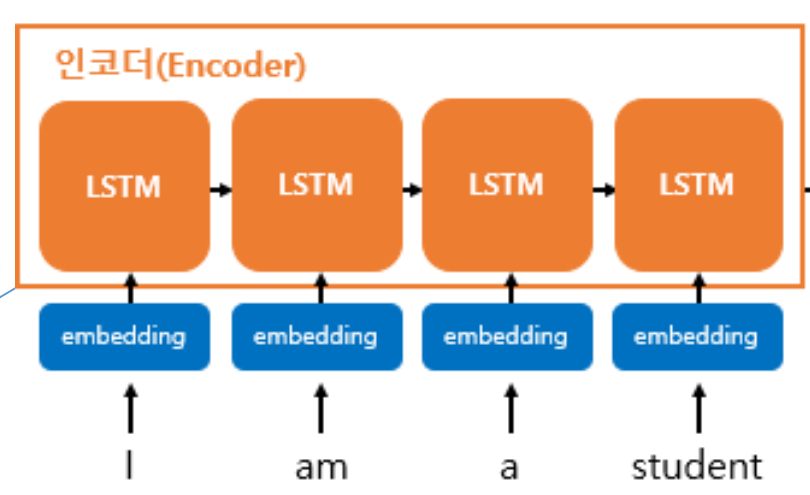

### LSTM layer

들어가기에 앞서 torch에서 제공하는 LSTM은 어떤 형태로 입력데이터를 주어야 하며, 어떤 형태로 출력 데이터를 반환하는지 확인하도록 합니다.

참고 [레퍼런스](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)


1. LSTM의 입력데이터 요약
  - **batch_first=True** 상황이기 때문에 (batch_size, seq_len, input_size)가 되어야 합니다.
  - input_size의 의미?
    - **모델 혹은 레이어 입장**에서 생각하면 편합니다.
    - 모델 입장에서 input의 크기가 무엇이지??
  - 모델(혹은 layer)의 input은 정수 인코딩된 값이 아니라 **embedding 벡터**을 사용하고 있습니다.
  - 그러니, **input_size는 embedding의 차원값**을 말합니다. 
    - 모델 입장에서 입력값으로 들어오는 것은 embedding이고 embedding의 크기는 결국 embedding의 차원이 되는 것.
  - seq_len은 그저 시퀀스의 길이를 말하고, 결국 몇번 반복해서(recurvise) 입력이 들어오는지 알려주는것이지, 입력하는 데이터(embedding)의 크기(size)와는 무관합니다.

아래의 사진을 참고해도 좋습니다!


encoder의 input :<br>
len([seq1, seq2, ...]) = batch_size<br>
seq:<br>
len([token1, token2,...]) = seq_len<br>
token1:<br>
len([e1, e2, e3...]) = embedding_dim


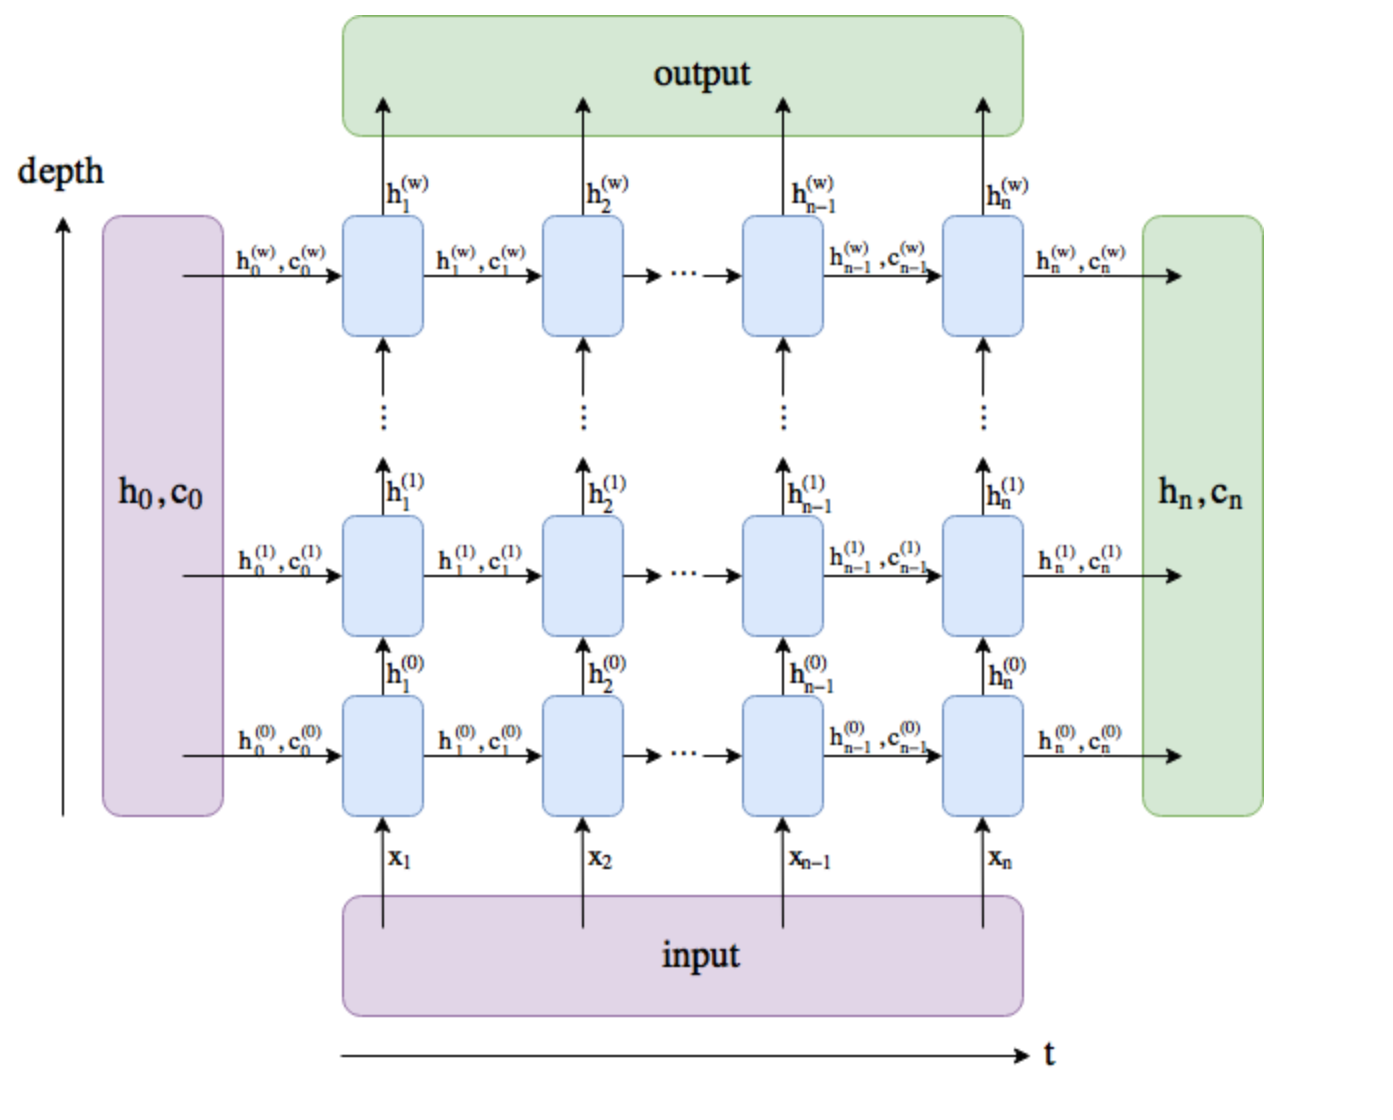

In [53]:
# 모델 구조를 얘기하기에 앞서 GRU(혹은 LSTM)를 torch에서는 어떻게 다루는지 확인하는 용도입니다.
# 중요한 것은 입력 값의 구조에 해당하는데 이는 위의 레퍼런스 링크를 꼭 확인하셔야 합니다.

## 확인용 샘플의 batch size
pBatch = 100
## 확인용 샘플에서 embedding의 차원
pInput_size = 3
## 확인용 샘플에서 sequence의 길이
seq_len = 10

## RNN block 1개가 확인용 샘플을 입력받았을 때 반환하는 vector의 차원 = hidden_size!
## 쉽게 생각해서 Linear에서도 입력 값을 원하는 차원으로 변환해주는 역할을 했었습니다. 
## 여기서도 동일하게 생각해보면, embedding dim --> hidden layer dim 으로 변환이 될거고, 
## 그 때 몇차원으로 보낼 것인지 얘기하는 것이 바로 hidden_size!
pHidden_size = 8

tmp = nn.LSTM(input_size=pInput_size, hidden_size=pHidden_size, num_layers=1, batch_first=True)
summary(tmp, (pBatch, seq_len, pInput_size))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [100, 10, 8]              416
Total params: 416
Trainable params: 416
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.00
Estimated Total Size (MB): 0.08

만약 LSTM말고 GRU를 사용한다면 Param #에서 값이 어떻게 바뀔까요?

### Embedding layer

[레퍼런스](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

여기서 Embedding layer의 방식을 이해하셔야 합니다.

1. embedding의 역할은 정수 인코딩된 것을 one-hot encoding을 거친 매우 긴 sparse vector들을 원하는 차원의 vector들로 표현하게 됩니다.
2. 중요한 것은 one-hot encoding의 차원은 결국 사용하는 token의 개수가 됩니다. 
  - one-hot encoding을 한다는 것은 결국 token 개수만큼의 차원을 가지는 벡터를 만들고 각 token마다 고유한 벡터를 할당합니다.
3. 그래서 Embedding layer에서 하는 역할은 "token 개수" 차원의 벡터(one-hot encoded)를 원하는 차원의 벡터로 transform해준다고 생각할 수 있습니다.
  - Linear Layer처럼 주어진 차원을 원하는 차원로 mapping하는 것으로 본다면 token_size이 곧 입력하는 데이터의 차원에 해당하고 이는 레퍼런스에서 확인할 수 있는 embedding_num입니다. 
  - 그리고 출력하는 차원은 결국 우리가 원하는 embedding_dim이 됩니다.
4. 여기서 embedding dim은 결국 LSTM입장에서 input_size에 해당되는 것입니다!(사진참고)

In [54]:
tmp = nn.Embedding(4, 2)

# 여기서 (4,2)의 matrix임을 알 수 있습니다.
# 즉 4개의 embedding을 2차원의 벡터로 만들어주는 embedding matrix가 Embedding layer의 weight의 역할입니다.
print(tmp.weight.size())
print(tmp.weight)

torch.Size([4, 2])
Parameter containing:
tensor([[-1.3217,  1.0713],
        [-0.0865, -2.5195],
        [-0.1809,  0.2375],
        [-0.5091, -0.2776]], requires_grad=True)


In [55]:
# 위의 embedding matrix에서 첫번째 row가 나온 것을 볼 수 있습니다.
tmp(torch.LongTensor([0]))

tensor([[-1.3217,  1.0713]], grad_fn=<EmbeddingBackward0>)

In [56]:
# 그렇다면 병렬처리를 해봅시다. 여러개의 index를 알려주면 여러개의 embedding vector를 알려줍니다.
tmp_idx = torch.LongTensor([0, 1])
print(tmp_idx.size())
print(tmp(tmp_idx).size())
tmp(tmp_idx)

torch.Size([2])
torch.Size([2, 2])


tensor([[-1.3217,  1.0713],
        [-0.0865, -2.5195]], grad_fn=<EmbeddingBackward0>)

In [57]:
# 이렇게 동시에 여러개의 embedding vector를 얻고자 할 때 입력하는 정수 인코딩된 값을 담는 "tensor"의 차원이 중요하게 됩니다.
tmp_idx = torch.LongTensor([[0], [1]])
print(tmp_idx.size())
print(tmp(tmp_idx).size())
tmp(tmp_idx)

torch.Size([2, 1])
torch.Size([2, 1, 2])


tensor([[[-1.3217,  1.0713]],

        [[-0.0865, -2.5195]]], grad_fn=<EmbeddingBackward0>)

사실 위의 2개의 셀은 동일한 작업을 합니다. 그렇지만 반환하는 차원이 다릅니다!

왜냐하면 입력하는 정수 인코딩 텐서의 차원이 (2,)과 (2,1)로 다르기 때문입니다.

이를 유의해서 이후에 사용하실 때 참고하시길 바랍니다!

In [58]:
# 알려준 token의 개수보다 더 큰 인덱스를 주면 어떻게 될까요? 에러가 나옵니다!

tmp(torch.LongTensor([7]))

IndexError: ignored

### Encoder Class

In [59]:
class Encoder(nn.Module):
  def __init__(self, in_size, hid_size, tok_size, bat_first=True, num_lay=1, bidirect=False):
    super(Encoder, self).__init__()
    # 여기서 hidden_size는 LSTM의 hidden_size로 embedding vector를 몇차원의 벡터로 transform할 것인지 말합니다!
    self.hidden_size = hid_size
   
    # 앞서 설명한 내용대로 전체 사용하는 token의 수를 embedding_num에 해당하고, 이를 몇차원의 embedding dim으로 표현할 것인지 말합니다.
    # 이 때 LSTM의 관점에서 embedding dim은 input_size에 해당해서 개념적으로 embedding_dim=in_size입니다.
    self.embedding = nn.Embedding(tok_size, in_size)

    # layer를 구성할 때 LSTM 내부의 layer의 개수도 조정할 수 있습니다.
    self.num_layers = num_lay

    # 이것은 bidirectional 방식을 사용할 것인지를 얘기하는데,
    # 이는 현재 과정에서 고려하지 않는 값이지만 LSTM 레이어를 설정할 때 필요한 값이라 기록하긴 했습니다.
    self.num_directional = 2 if bidirect else 1

    self.batch_first = bat_first
    self.lstm = nn.LSTM(in_size, 
                        hid_size, 
                        num_layers = num_lay,
                        batch_first = bat_first,
                        bidirectional=bidirect)

  def forward(self, x, hidden):
    """
    현재 전체 전처리부터 모델링 과정을 batch_first=True환경에서 진행하고 있으니 이를 유의하시길 바랍니다.
    batch_first=True이기에 입력값(x)의 차원은 다음과 같고, 
    hidden_state에 해당하는 값도 batch_size가 먼저 나오게 됩니다.
    x: (batch_size, seq_len)
    hidden: (num_directional*num_layers, batch_size, hidden_size)
    
    개념적으로 보면 우리가 전처리한 시퀀스(seq)는
    seq = [정수인코딩1, 정수인코딩2, ..]에 해당합니다.
    여기서 중요한 것은 들어오는 값이 정수인코딩된 값입니다!!
    
    이런 seq들이 모여서 만들어진 것이 
    x = [seq1, seq2, ...]에 해당합니다.

    그래서 len(x) = batch_size가 되는 것입니다!    
    """

    # 여기서 중요한 점은 입력값으로 정수인코딩된 값이 들어오는 것이고, embedidng layer를 거치면서 
    # 정수인코딩값이 vector로 바뀌게 됩니다!!
    # 그런데 이상하지 않나요? 위에서 one-hot된 벡터를 입력해서 embedding vector로 바꿔주는데
    # 정수인코딩 값만 넣다니?!
    # 이는 사실 torch의 Embedding layer가 그런 역할까지 포함하고 있는 것이고, 
    # Embedding layer를 사용할 땐 "정수"인코딩된 값을 넣어주면 대응하는 embedding vector를 반환해줍니다.
    # 여기서 "정수"인코딩 값을 사용해야 하기 때문에 앞에서 .long()과정이 들어간 것입니다.
    # 안그럼 에러뜰거에요
    # emb : (batch_size, seq_len, input_size)
    emb = self.embedding(x)

    # LSTM에서 하는 연산은 결국 Linear와 크게 다르지 않습니다.
    # input_size의 임베딩 벡터를 hidden_size의 벡터로 바꾸게 되니 output의 차원은
    # out : (batch_size, seq_len, hidden_size)

    # 이와 달리 hidden_state는 그 구조가 조금 다릅니다.
    # 여기서 num_layer가 사용되는 것은 LSTM에서 내부의 layer가 많아질수록 그 만큼 hidden state가 더 나와야 할 것입니다.
    # 위에 LSTM layer에서 인용한 사진이 잘 설명하는데 내부에서 layer가 많아질수록 hidden state도 많아지게 될 것입니다.
    # 그리고 최종 반환하는 hidden_state는 앞의 시퀀스의 정보를 다 포함하는 벡터가 나온 것이고,
    # 그 모든 정보를 가지고 있는 벡터의 차원이 바로 hidden_size입니다.
    # 즉 layer마다 batch 만큼의 context vector가 담겨져 있다! 생각할 수 있을거에요
    # hidden: (num_layers, batch_size, hidden_size)
    out, hidden = self.lstm(emb, hidden)
    return out, hidden

## Decoder

decoder의 역할 상 단어하나를 넣었을 때, 다음 단어를 예측하게 되고,
그 다음 단어를 다시 decoder의 input으로 **순차적**으로 사용하게 됩니다. 

그렇기 때문에 단어를 **하나씩 넣게 되기 때문**에 seq_len=1인 상황이 됩니다. 즉 LSTM입장에서는 그전까지의 context와 입력 단어를 주었을 때 다음 단어를 예측하는 이이 됩니다. 즉, 단어를 하나 넣고 하나 나오는 구조가 되기 때문에 decoder에서 LSTM이 보고 있는 단어는 1개가 되어서 seq_len=1인 상황이 되는 것입니다.

이것이 최종 seq2seq 모델 구현에 어떻게 영향끼치는지 구현할 때 참고하시면 됩니다.

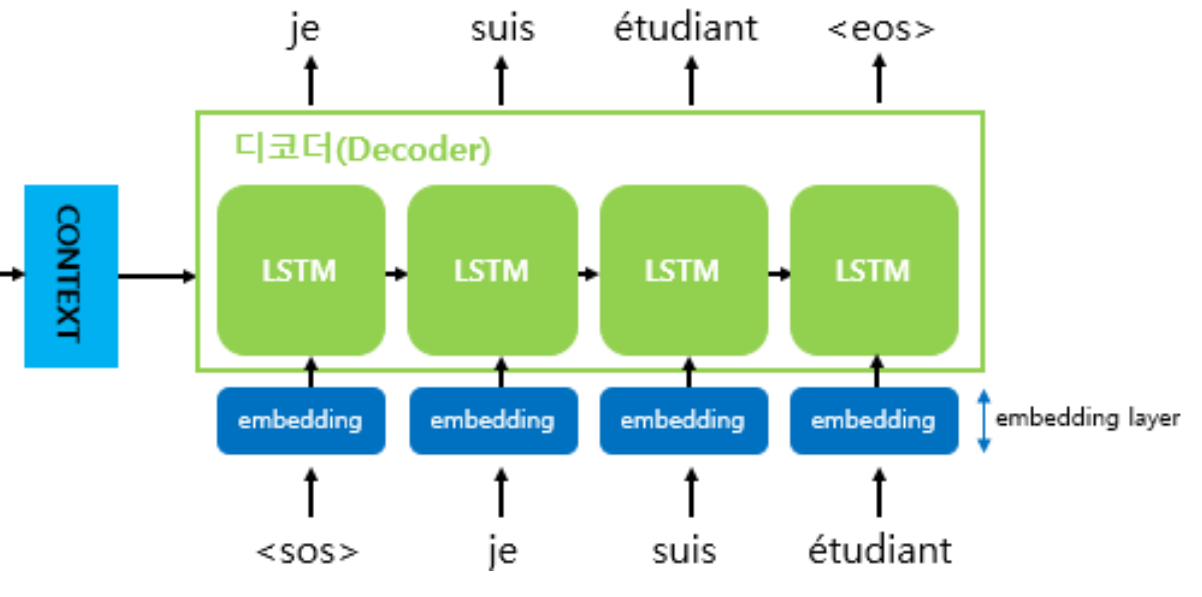

In [60]:
class Decoder(nn.Module):
  def __init__(self, in_size, hid_size, tok_size, bat_first=True, num_lay=1, bidirect=False):
    super(Decoder, self).__init__()

    # 대부분의 방식은 사실 Encoder와 비슷하게 흘러갑니다.

    # LSTM이 embedding을 몇차원의 벡터로 변환할지 정하는 값입니다.
    self.hidden_size = hid_size

    # 여기서도 번역해야하는 언어의 token을 embedding 해야하고 이  때 embedding vector의 차원이 결국 LSTM입장에서의 Input size가 됩니다.
    self.embedding = nn.Embedding(tok_size, in_size)

    self.num_layers = num_lay
    self.num_directional = 2 if bidirect else 1
    self.batch_first = bat_first
    self.lstm = nn.LSTM(in_size, 
                        hid_size, 
                        num_layers = num_lay,
                        batch_first = bat_first,
                        bidirectional=bidirect)
    self.relu =  nn.ReLU()

    # 여기서 Encoder와 차이가 생기는데,
    # Decoder는 입력된 단어와 context를 보고 다음 단어를 "예측"해야합니다.
    # 그렇기 때문에 hidden_size의 벡터를 token의 개수만큼 다시 mapping해주어야
    # 각 token별 점수로 만들어줘야 최종 예측을 할 수 있습니다.
    # 그래서 최종 값을 반환할 때에는 총 토큰 수만큼으로 만들어 줘야 토큰별 확률을 계산하게 됩니다.
    self.fc1 = nn.Linear(hidden_size, tok_size)
    
  def forward(self, x, hidden):
    """
    x: (batch_size, seq_len=1)
    hidden: (num_directional*num_layers, batch_size, hidden_size)
    """
    
    # 여기서 조금 trivial한 점을 고려해야 합니다.
    # Embedding layer를 거치고 나왔을 때 차원은 아래와 같아야 하고 이를 위해서 x[:, 0]과 .unsqueeze(1)을 한 것입니다. 이것은 정해진 답은 없고, 필요하신 대로 이용하셔도 좋습니다!
    # emb: (batch_size, seq_len=1, input_size)   
    # x[:, 0] : (batch_size, )
    # self.embedding(x[:, 0]) : (batch_size, input_size)
    # self.embedding(x[:, 0]).unsqueeze(1) : (batch_size, 1, input_size)
    emb = self.embedding(x[:, 0]).unsqueeze(1)
    # 이거 말고도 동일한 차원을 가지도록 처리하려면 어떻게 해야할까요?
    # emb = self.embedding(~~)~~

    # relu를 취한 것은 별다른 이유가 없이 참고한 레퍼런스와 동일한 구조로 해본 것입니다.
    out = self.relu(emb)

    # LSTM을 사용한다는 점에서 Encoder와 동일하게 output과 hidden_state는 동일한 구조로 반환하게 됩니다.
    # 다만 seq_len은 decoder에서 1이 된다는 점입니다!
    # out : (batch_size, seq_len=1, hidden_size)
    # hidden: (num_layers, batch_size, hidden_size)
    out, hidden = self.lstm(out, hidden)

    # 기존의 output에서 seq_len =1이니 squeeze하게 된다면 (batch_size, hidden_size)가 되고
    ## out.squeeze(1) : (batch_size, hidden_size)
    # 이 상태에서 FC layer를 통해 최종 토큰 개수 만큼 값을 반환하게 됩니다.
    # out: (batch_size, tok_size) : batch의 element별로 token에 대해 예측값을 반환
    out = self.fc1(out.squeeze(1))
    return out, hidden

In [61]:
def init_hidden(self, x):
  """
  레퍼런스 참고할 때 hidden_state 구조와 동일하게 되어야 합니다.
  여기서 보면 
  when batch_first=True (num_directional*num_layers, batch_size, hidden_size)
  """
  batch_size = x.size(0) if self.batch_first else x.size(1)
  h0 = torch.zeros(self.num_layers*self.num_directional, batch_size, self.hidden_size).to(device)
  c0 = torch.zeros(self.num_layers*self.num_directional, batch_size, self.hidden_size).to(device)
  return h0, c0

## Seq2Seq

앞서 구현한 Encoder와 Decoder를 이용하여 최종 구현을 진행해보는 것입니다! 

encoder에서 계산한 결과가 context vector가 되고, 이 고정된 크기의 context vector는 입력한 시퀀스의 정보를 다 가지고 있는 벡터가 됩니다.

decoder에서는 context 벡터를 이용해서 시작토큰(SOS)부터 시작해 한 단어씩 예측하고, 그 결과를 다시 입력으로 사용하는 방식으로 학습하게 됩니다.

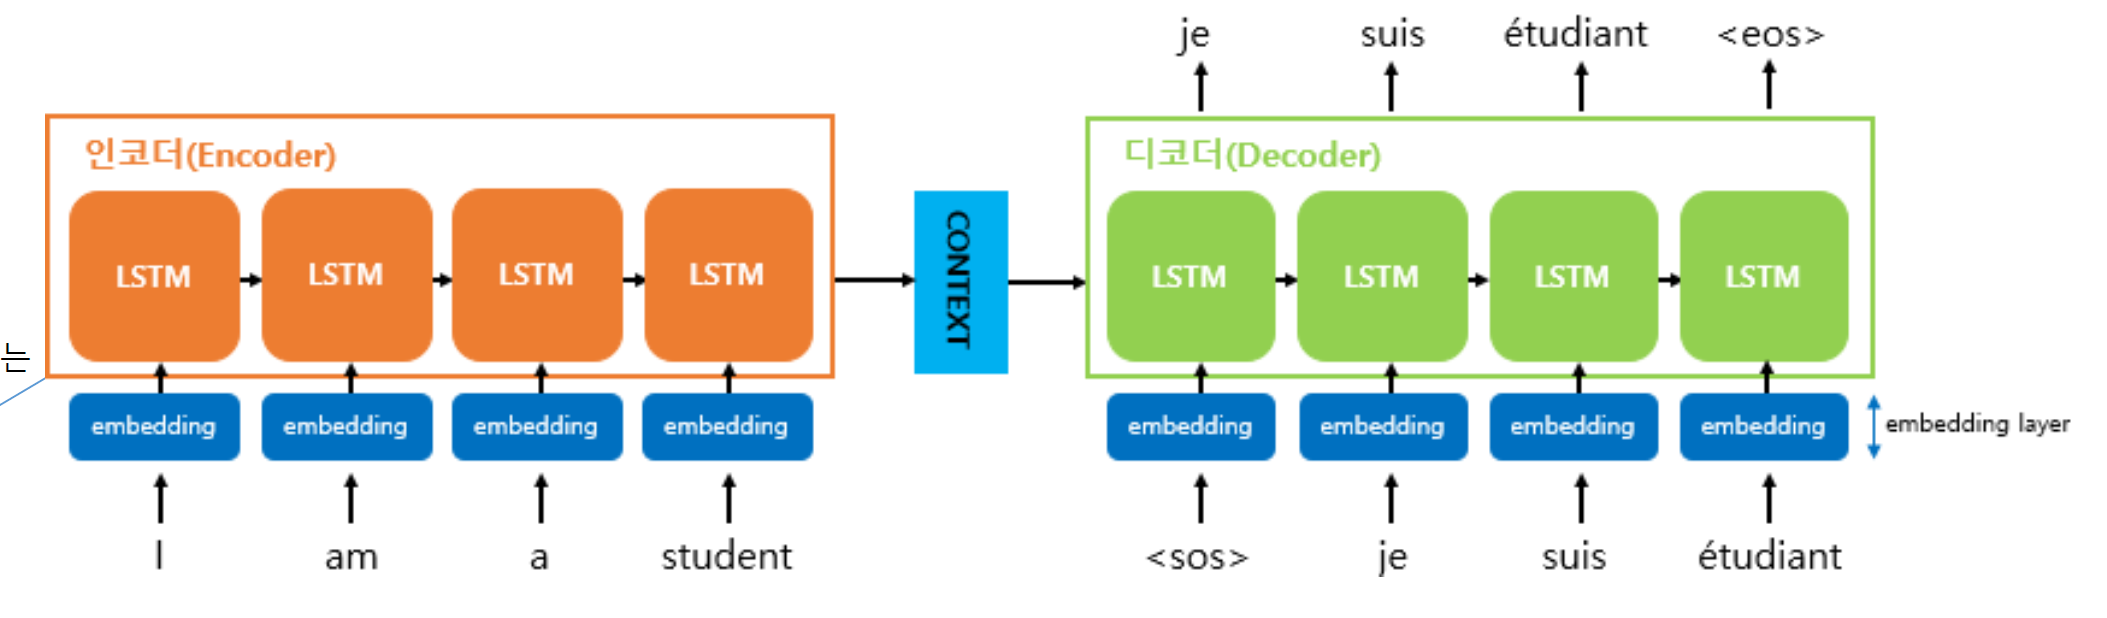

In [62]:
class Seq2Seq(nn.Module):
  def __init__(self, enc, dec):
    super(Seq2Seq, self).__init__()
    assert enc.hidden_size == dec.hidden_size
    assert enc.num_layers == dec.num_layers

    self.encoder = enc
    self.decoder = dec

  def forward(self, enc_inp, dec_inp, use_teacher_force=True):
    """
    enc_inp : (batch_size, enc_seq_len)
    dec_inp : (batch_size, dec_seq_len)
    """

    batch_size = enc_inp.size(0)
    enc_seq_len = enc_inp.size(1)
    dec_seq_len = dec_inp.size(1)
    # 최종 반환하는 것은 "토큰 별" score 값이니 이 점을 이용해서 token 개수 확인
    token_size =  self.decoder.fc1.out_features

    # decoder의 결과값은 출력 시퀀스에서 각 위치에 들어갈 token들의 확률(점수) 예측값 저장할 것입니다.
    # 그래서 구조는 (batch_size, seq_len, token_size)가 됩니다.
    # 즉 decoder는 step 마다 한 토큰씩 예측하게 되고 이를 총 seq_len만큼 진행해서 모으게 됩니다.
    # 이를 저장할 변수는 outputs
    # 이 때 seq_len은 decoder의 seq_len에 해당
    outputs = torch.zeros(batch_size, dec_seq_len, token_size)

    # Step 0: Encoder의 forward에 필요한 초기 hidden, cell state 계산
    enc_init_hidden = init_hidden(self.encoder, enc_inp)

    # Step 1: Encoder를 이용하여 context 벡터 계산
    # 중요한 점은 Encoder의 output이 아닌, hidden_state에 해당한다!!!
    _, context = self.encoder(enc_inp, enc_init_hidden)

    # Step 2: Decoder의 초기 입력값을 먼저 확인
    # 여기서 Decoder의 입력값이란 context vector 말고 단어들을 말합니다.
    # 그리고 첫 입력값은 <SOS>가 사용되어야 한다는 것
    # 이는 decoder의 input에서 첫번째 값에 해당하고 지금 상황에서는 앞서 사용한 \t을 알려주는 토큰이 사용되어야 합니다.
    # 그리고 Decoder의 인풋은 위에서 구현할 때  x: (batch_size, seq_len=1) 라고 했고 이 때 seq_len은 1이 됩니다.
    # 즉 이 구조를 맞춰서 넣어줘야 돌아가기에
    # (batch_size, dec_seq_len)의 차원을 맞춰야 하고, dec_seq_len=1이라서 마지막 차원에 unsqueeze 진행
    dec_inp_t = dec_inp[:, 0].unsqueeze(-1)

    # Step 3: Decoder를 이용하여 하나하나 계산에 사용
    # Encoder의 최종 리턴한 hidden state가 context 벡터고 이게 decoder입장에서보면 init_hidden에 해당합니다.
    # 또한 앞서 첫 입력값은 직접 할당했으니 전체 loop 시작은 1부터 하면 됩니다.
    # loop의 순서는 output 계산 --> 예측 --> 다음 입력값 업데이트
    # 이 순서라서 range는 1부터 시작하게 만들면 됩니다.
    dec_hidden = context
    for t in range(1, dec_seq_len):
      out, dec_hidden = self.decoder(dec_inp_t, dec_hidden)
      # 각 step별 결과물 = 해당 시점에서 각 토큰별 등장 확률(점수)값 기록
      outputs[:, t, :] = out

      if use_teacher_force:
        # teacher force를 사용하는 경우에는 실제 input에서 입력값을 넣어야 해서 decoder의 input값을 이용해서 업데이트를 합니다.
        # 그리고 모델이 돌아가기 위해서 차원도 차원 맞출 필요 존재힙니다.
        # 즉, indexing하게 되버리면 dec_inp차원과 맞지 않아서 unsqueeze 진행
        dec_inp_t = dec_inp[:, t].unsqueeze(-1)
      else:
        # keepdim을 통해 차원수 유지해줘서 구조를 동일하게 맞춘다.
        dec_inp_t = out.argmax(1, keepdim=True)

    return outputs

# Setup

In [63]:
# padding에 해당하는 token도 고려해서 +1!
enc_token_size = len(src_to_index)+1
dec_token_size = len(tar_to_index)+1

# hyper param
input_size = 256
hidden_size = 256

In [64]:
encoder = Encoder(input_size, hidden_size, enc_token_size)
decoder = Decoder(input_size, hidden_size, dec_token_size)

model = Seq2Seq(encoder, decoder).to(device)

## 생략된 내용들

모델 생성하는 과정에서 초기값이나 등등 부수적인 부분들은 현재 과제 코드상에서 생략되었습니다. 모델 개선에 관심있으신 분들은 수행하셔도 좋습니다.

In [65]:
# ~~~

# Train

In [73]:
def train(model, loader, optimizer, cri):
  model.train()
  loss_ep = 0

  for enc_input, dec_input, dec_target in loader:
    optimizer.zero_grad()

    # 여기서 output은 seq2seq 모델의 결과값임을 유의해야합니다!
    # output: (batch_size, seq_len, token_size)
    output = model(enc_input.to(device), dec_input.to(device), use_teacher_force=True)
    token_size = output.size(-1)

    # 지금 [문장, 문장, ...] 구조에서 문장들을 그냥 순서대로 이어 붙인 것
    # 이는 loss 계산을 쉽게 하기 위해 구조를 조정
    # output : (batch_size * seq_len, token_size)
    output = output.view(-1, token_size)

    # 위와 동일한 방식으로 label 값도 동일한 구조로 만들어주려고 view 실행
    # dec_target: (batch_size, dec_seq_len)
    # 즉 그냥 1열로 다 펴 버리면 CrossEntropyloss를 위한 구조 완성
    # target L (batch_size*dec_seq_len,)
    target = dec_target.view(-1)

    loss = cri(output, target)

    loss.backward()
    optimizer.step()

    loss_ep += loss.item()
  return loss_ep/len(loader)

# Evaluation

In [66]:
import pandas as pd

In [67]:
def val(model, loader, cri):
  # 평가할 땐 loss말고 예측한 결과도 저장할 것
  # 이것이 바로 result
  result = torch.Tensor()

  model.eval()
  loss_ep = 0
  with torch.no_grad():
    for enc_input, dec_input, dec_target in loader:
      # output: (batch_size, seq_len, token_size)
      output = model(enc_input.to(device), dec_input.to(device), use_teacher_force=False)

      # 예측 값을 저장
      decode_idx = output.argmax(2).detach().cpu()
      # 각 시점별 예측 결과를 저장
      result = torch.cat((result, decode_idx), dim=0)
  
      # 지금 [문장, 문장, ...] 구조에서 문장들을 그냥 순서대로 이어 붙인 것
      # loss 계산을 위한 조정
      # train과 동일한 이유 
      token_size = output.size(-1)
      output = output.view(-1, token_size)

      # 위와 동일한 방식으로 label 값도 조정
      # dec_target: (batch_size, dec_seq_len)
      # 즉 그냥 1열로 다 펴 버리면 CrossEntropyloss를 위한 구조 완성
      # target L (batch_size*dec_seq_len,)
      target = dec_target.view(-1)

      loss = cri(output, target)
      loss_ep += loss.item()
  return loss_ep/len(loader), result

In [68]:
# 아래의 dictionary는 정수 인코딩 값을 넣으면 해당하는 원래 알파벳이 나옴
# padding도 처리해야하기 때문에 0은 그냥 ''으로 처리
# 이는 예측한 정수 인코딩 값을 실제 단어로 바꾸기 위한 것이라서 key, value를 바꿔주는 방식
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())
index_to_tar[0] = ''
index_to_src[0] = ''

In [69]:
def decode(model, sample):
  # 정수 인코딩된 것을 실제 단어로 바꾸는 과정이고,과제 수행에 중요한 것은 아님
  enc_input, dec_input, dec_output = sample
  enc_input = enc_input.unsqueeze(0)
  dec_input = dec_input.unsqueeze(0)
  
  model.eval()
  with torch.no_grad():
    output = model(enc_input.to(device), dec_input.to(device), use_teacher_force=False)
    decode_idx = output.argmax(2)

  sentence_inp = pd.Series(enc_input.squeeze(0).detach().cpu().numpy()).apply(lambda x: index_to_src[x])
  sentence_out = pd.Series(decode_idx.squeeze(0).detach().cpu().numpy()).apply(lambda x: index_to_tar[x])
  sentence_act = pd.Series(dec_output.detach().cpu().numpy()).apply(lambda x: index_to_tar[x])

  print(f"입력 문장({len(sentence_inp)}) : {''.join(sentence_inp.tolist())}")
  print(f"실제 문장({len(sentence_act)}) : {''.join(sentence_act.tolist())}")
  print(f"예측 문장({len(sentence_out)}) : {''.join(sentence_out.tolist())}")

In [70]:
import time
from tqdm import tqdm
from torch import optim

# Run

In [74]:
# 학습은 아래의 코드를 이용하여 진행

train_loader = DataLoader(train_dataset, batch_size=1024)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

train_loss = []
val_loss = []

epochs = 30
for epoch in tqdm(range(epochs)):
  start = time.time()

  train_loss_ep = train(model,train_loader,optimizer, criterion)
  val_loss_ep, val_token = val(model, val_loader, criterion)

  train_loss.append(train_loss_ep)
  val_loss.append(val_loss_ep)
  if epoch % 2 == 0:
    print(f"Epoch : {epoch}")
    print(f"Train Loss : {train_loss_ep:.4f}")
    print(f"Val Loss : {val_loss_ep:.4f}")
    decode(model, val_dataset[100])


  3%|▎         | 1/30 [00:43<21:10, 43.80s/it]

Epoch : 0
Train Loss : 1.0106
Val Loss : 5.9992
입력 문장(24) : Tom won.

실제 문장(75) :  Tom a gagné. 

예측 문장(75) : J ine ete ote ote ote ote ote  ote ote ote  ote ote ote  ote ote ote  ote 


  3%|▎         | 1/30 [01:13<35:33, 73.58s/it]


KeyboardInterrupt: ignored

In [ ]:
# 학습을 진행한 다음, 모델 백업해놓기
torch.save(model.state_dict(), 'model.pt')